In [3]:
import top_k
import numpy as np
import pandas as pd

# Namaak benade 2018

In [19]:
# using projebudget = 65
ct costs and utils from benade 2018
P = 10

project_prizes= {0:10, 1:20, 2:3, 3:8, 4:5, 5:5, 6:10, 7:10, 8:30, 9:25}
possible_sets = top_k.get_possible_sets(project_prizes, budget)

In [20]:
N = 720
epsilon = 15

base_util = np.asarray([5.8, 2.3, 29.3, 9.5, 14.8, 9.4, 5.4, 14.9, 6.7, 1.9])
utilities = top_k.make_voter_utils(base_util, epsilon, N)

In [21]:
max_set = top_k.max_utility(possible_sets, utilities)


In [22]:
for k in range(1, P):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, utilities, P)
        print(votes)
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, project_prizes)
        dist_score = top_k.calc_dist_score(winners, max_set, utilities)

#         print("util", util_score)
#         print("egal", egal_score)
#         print("comp", comp_score)
#         print("dist", dist_score)

---------k------------ 1
Counter({1: 127, 9: 125, 6: 96, 0: 91, 8: 89, 5: 67, 3: 56, 7: 39, 4: 28, 2: 2})
---------k------------ 2
Counter({1: 249, 9: 247, 6: 194, 0: 189, 8: 158, 3: 137, 5: 115, 7: 83, 4: 61, 2: 7})
---------k------------ 3
Counter({1: 342, 9: 335, 6: 284, 0: 275, 8: 254, 3: 212, 5: 188, 7: 138, 4: 106, 2: 26})
---------k------------ 4
Counter({1: 437, 9: 402, 6: 374, 0: 357, 8: 322, 3: 284, 5: 275, 7: 208, 4: 176, 2: 45})
---------k------------ 5
Counter({1: 512, 9: 489, 6: 441, 0: 435, 8: 398, 3: 370, 5: 363, 7: 283, 4: 238, 2: 71})
---------k------------ 6
Counter({1: 575, 9: 564, 0: 513, 6: 506, 8: 485, 5: 447, 3: 447, 7: 354, 4: 312, 2: 117})
---------k------------ 7
Counter({1: 634, 9: 607, 0: 589, 6: 578, 8: 568, 5: 528, 3: 519, 7: 438, 4: 415, 2: 164})
---------k------------ 8
Counter({1: 677, 9: 660, 0: 652, 8: 639, 6: 636, 5: 600, 3: 598, 7: 529, 4: 525, 2: 244})
---------k------------ 9
Counter({1: 705, 9: 699, 8: 689, 6: 689, 0: 689, 3: 674, 5: 670, 4: 632

In [23]:
df = pd.read_csv("results/results_P10_ep15_N720_B65_min10_max25_L100.csv")

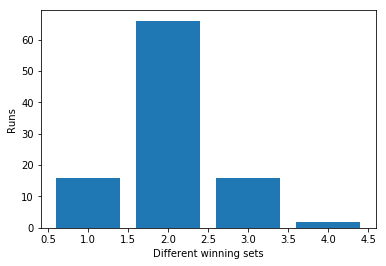

In [24]:
from collections import Counter
from matplotlib import pyplot as plt

winners = []
for i, row in df.iterrows():
    win = []
    for i in range(1,10):
        get = "k_" + str(i) + "_winners"
        win.append(int(row[get]))
    winners.append(win)
    
winner_sets = []
for i, result in enumerate(winners):
    winner_sets.append(len(set(result)))
    
c = Counter(winner_sets)
plt.bar(list(c.keys()), c.values())
plt.xlabel("Different winning sets")
plt.ylabel("Runs")
plt.show()

# Epistemic accuracy

In [25]:
from collections import defaultdict
from sklearn.preprocessing import normalize


def epistemic_topk(probs, k, N):
    votes = []
    projects = list(range(len(probs)))
    # Create noisy prob vectors for voters
    probs = np.tile(probs, (N,1))
    noise = np.random.normal(0.07, 0.05, (N, len(projects)))
    probs += noise
    # Set all negative probs to positive number and 
    probs[probs < 0] = 0.0001
    probs = normalize(probs, "l1", axis=1)
    # Every voters uses prob distr to vote
    for i in range(N):
        vote = np.random.choice(projects, k, replace=False, p=probs[i])
        votes += list(vote)
    return Counter(votes)


In [30]:
P = 10 
epsilon = 10
N = 500
budget = 40
min_prize = 5
max_prize = 25

In [31]:
values = top_k.make_base_util(P)
probs = values / np.sum(values)
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
best_set = top_k.best_outcome(values, possible_sets)

In [32]:
utilities = top_k.make_voter_utils(values, epsilon, N)


In [33]:
for k in range(1, P):
    print("---------k------------", k)
    # calculate scores for all projects
    votes = epistemic_topk(probs, k,  N)
    print(votes)
    
    # determine the winning projects
    winners = top_k.greedy_allocation(votes, project_prizes, budget)
        
    # Epistemic accuracy
    print("win:", list(winners), "--best",  best_set[0])
    correct = 0
    for alt in list(winners):
        if alt in best_set[0]:
            correct += 1
    
    acc = correct/len(best_set[0])
    print(acc)
                


---------k------------ 1
Counter({5: 68, 8: 65, 9: 55, 6: 53, 3: 52, 2: 50, 1: 48, 0: 47, 4: 39, 7: 23})
win: [8, 2, 5] --best [7, 9]
0.0
---------k------------ 2
Counter({3: 130, 5: 119, 8: 117, 0: 114, 4: 98, 6: 95, 2: 90, 9: 89, 1: 88, 7: 60})
win: [0, 3, 4, 5, 6] --best [7, 9]
0.0
---------k------------ 3
Counter({8: 183, 3: 181, 5: 179, 9: 172, 0: 167, 6: 154, 1: 138, 2: 126, 4: 115, 7: 85})
win: [8, 3] --best [7, 9]
0.0
---------k------------ 4
Counter({8: 270, 3: 235, 5: 226, 0: 225, 9: 221, 6: 210, 4: 173, 2: 172, 1: 148, 7: 120})
win: [8, 3] --best [7, 9]
0.0
---------k------------ 5
Counter({8: 329, 5: 289, 0: 283, 9: 278, 3: 268, 4: 250, 6: 239, 1: 218, 2: 195, 7: 151})
win: [8, 4, 5] --best [7, 9]
0.0
---------k------------ 6
Counter({8: 362, 5: 357, 3: 345, 0: 342, 9: 318, 6: 308, 2: 267, 1: 264, 4: 254, 7: 183})
win: [8, 2, 5] --best [7, 9]
0.0
---------k------------ 7
Counter({8: 420, 5: 410, 9: 382, 0: 376, 3: 372, 6: 345, 2: 331, 4: 321, 1: 319, 7: 224})
win: [8, 2, 5]

# Different base utils

In [1]:
P = 10 
epsilon = 10
N = 500
budget = 40
min_prize = 5
max_prize = 25

In [24]:
prizes = top_k.make_projects(min_prize, max_prize, P)
possible_sets = top_k.get_possible_sets(prizes, budget)
# best_set = top_k.best_outcome(values, possible_sets)
max_set = top_k.max_utility(possible_sets, utilities)

In [20]:
# Create different base utilities 
base_util, vote_util = [], []
for i in range(5):
    util = top_k.make_base_util(P)
    base_util.append(util)    
    utilities = top_k.make_voter_utils(util, epsilon, int(N/5))
    vote_util.append(utilities)
voter_utilities = np.vstack(vote_util)

In [28]:
for k in range(1, P):
        print("---------k------------", k)
        # calculate scores for all projects
        votes = top_k.k_approval(k, voter_utilities, P)
        
        # determine the winning projects
        winners = top_k.greedy_allocation(votes, prizes, budget)
        print(winners)
        # calculate loss
        util_score = top_k.calculate_sw(utilities, winners)
        egal_score = top_k.calculate_sw(utilities, winners, egal=True)
        # nash_score = calculate_sw(utilities, winners, nash=True)
        nash_score = 0

        comp_score = top_k.calc_compare_score(winners, max_set, prizes)
        dist_score = top_k.calc_dist_score(winners, max_set, utilities)

        print("util", util_score)
        print("egal", egal_score)
        print("comp", comp_score)
        print("dist", dist_score)

---------k------------ 1
{8, 2, 5, 7}
util 0.3813302143574217
egal 0.15805079796309102
comp 21.03
dist 1.5689610672171137
---------k------------ 2
{8, 3, 5}
util 0.27617018362327217
egal 0.04910878322455006
comp 11.52
dist 2.4140401415143264
---------k------------ 3
{8, 4, 5, 7}
util 0.3476532650290453
egal 0.1436761093027008
comp 20.04
dist 1.7524745976188074
---------k------------ 4
{8, 4, 5, 7}
util 0.3476532650290453
egal 0.1436761093027008
comp 20.04
dist 1.7524745976188074
---------k------------ 5
{0, 8, 5}
util 0.26322000884060587
egal 0.0804260552504591
comp 10.74
dist 2.481029516069195
---------k------------ 6
{0, 8, 5}
util 0.26322000884060587
egal 0.0804260552504591
comp 10.74
dist 2.481029516069195
---------k------------ 7
{0, 8, 5}
util 0.26322000884060587
egal 0.0804260552504591
comp 10.74
dist 2.481029516069195
---------k------------ 8
{8, 3, 5}
util 0.27617018362327217
egal 0.04910878322455006
comp 11.52
dist 2.4140401415143264
---------k------------ 9
{3, 4, 5}
util 0.